<a href="https://colab.research.google.com/github/AlexanderCardarasUCSC/EEG-Decoding-to-Images/blob/main/CSE_247_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EEG decoding to images - Load data

**Complete the following steps before running the cells below**

1.
Change runtime to GPU 

>Runtime > Change runtime type > GPU

2.
For each of the following link, add a Google Drive shortcut to your Drive root folder(My Drive):

>https://drive.google.com/drive/folders/1z8wcew5R7GCeu5s7SSsWw8bUcx1urVmk?usp=sharing

**Mount drive**

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


**Run the following cells to load eeg and/or image data**

#### Load eeg data

**Uncomment one of the following blocks**

*5-95Hz*

In [ ]:
# !mkdir -p /content/data/eeg
# !cp /content/gdrive/MyDrive/EEG2Image/eeg_5_95_std.pth /content/data/eeg/
# eeg_path = "/content/data/eeg/eeg_5_95_std.pth"

14-70Hz

In [ ]:
# !mkdir -p /content/data/eeg
# !cp /content/gdrive/MyDrive/EEG2Image/eeg_14_70_std.pth /content/data/eeg/
# eeg_path = "/content/data/eeg/eeg_14_70_std.pth"

*55-95Hz*

In [ ]:
!mkdir -p /content/data/eeg
!cp /content/gdrive/MyDrive/EEG2Image/eeg_54_95_std.pth /content/data/eeg/
eeg_path = "/content/data/eeg/eeg_54_95_std.pth"

#### Load image data

In [2]:
!mkdir -p /content/data/images
!wget -q https://raw.githubusercontent.com/AlexanderCardarasUCSC/EEG-Decoding-to-Images/main/image_utils.py /content
!cp /content/gdrive/MyDrive/EEG2Image/data/images.npy /content/data/images
!cp /content/gdrive/MyDrive/EEG2Image/data/image_labels.npy /content/data/images

**Example load image**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import image_utils

In [4]:
images, labels = image_utils.load_images()

(36000, 64, 64, 3)


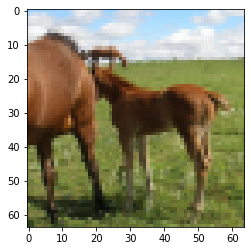

In [5]:
print(images.shape)
plt.imshow(images[0])

# Baseline GAN

**Complete the following steps before running the cells below**

1. Follow directions in the Load data section to load image data

>Run the cells under the header **Load image data**

**Import libraries**

In [3]:
# example of fitting an auxiliary classifier gan (ac-gan) on fashion mnsit
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv1D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot
import numpy as np
import matplotlib.pyplot as plt
import image_utils

**Discriminator architecture**

In [9]:
# define the standalone discriminator model
def define_discriminator(in_shape=(64,64,3), n_classes=40):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=in_shape)
	# downsample to 14x14
	fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# normal
	fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# downsample to 7x7
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU( alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# normal
	fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# real/fake output
	out1 = Dense(1, activation='sigmoid')(fe)
	# class label output
	out2 = Dense(n_classes, activation='softmax')(fe)
	# define model
	model = Model(in_image, [out1, out2])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
	return model


**Generator architecture**

In [17]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=40):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	# li = Embedding(n_classes, 50)(in_label)
	li = Embedding(n_classes, 200)(in_label)
	# linear multiplication
	# n_nodes = 7 * 7
	n_nodes = 16 * 16 * 3
	li = Dense(n_nodes, kernel_initializer=init)(li)
	# reshape to additional channel
	# li = Reshape((7, 7, 1))(li)
	li = Reshape((16, 16, 3))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	# n_nodes = 384 * 7 * 7
	n_nodes = 384 * 16 * 16
	gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
	gen = Activation('relu')(gen)
	# gen = Reshape((7, 7, 384))(gen)
	gen = Reshape((16, 16, 384))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 14x14
	gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
	gen = BatchNormalization()(gen)
	gen = Activation('relu')(gen)
	# upsample to 28x28
	# gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	gen = Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	out_layer = Activation('tanh')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model

**GAN architecture**

In [6]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# connect the outputs of the generator to the inputs of the discriminator
	gan_output = d_model(g_model.output)
	# define gan model as taking noise and label and outputting real/fake and label outputs
	model = Model(g_model.input, gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
	return model


**Helper functions**

In [124]:
# load images (60000, 28, 28, 1) (60000,)
def load_real_samples_old():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return [X, trainy]
  

# load images
def load_real_samples():
  # load dataset
  images, labels = image_utils.load_images()
  (trainX, trainY), (testX, testY) = image_utils.split_data(images, labels)
	# expand to 3d, e.g. add channels
  X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
  X = X.astype('float32')
	# scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  print(X.shape, trainY.shape)
  return [X, trainY]
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=40):
  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  z_input = x_input.reshape(n_samples, latent_dim)
  # generate labels
  labels = randint(0, n_classes, n_samples)
  return [z_input, labels]
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

def generate_fake_class_sample(generator, class_label, latent_dim, n_samples):
  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  z_input = x_input.reshape(n_samples, latent_dim)
  labels_input = np.asarray([class_label for i in range(n_samples)])
  # predict outputs
  images = generator.predict([z_input, labels_input])
  # create class labels
  y = zeros((n_samples, 1))
  return [images, labels_input], y
 
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
	# prepare fake examples
	[X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(100):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		# pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
		pyplot.imshow(X[i, :, :, 0])
	# save plot to file
	filename1 = 'generated_plot_%04d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%04d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=64):
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_steps):
		# get randomly selected 'real' samples
		[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
		# update discriminator model weights
		_,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
		# generate 'fake' examples
		[X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator model weights
		_,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
		# prepare points in latent space as input for the generator
		[z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		_,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
		# summarize loss on this batch
		print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
		# evaluate the model performance every 'epoch'
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, latent_dim)

**Train GAN**

In [125]:
# size of the latent space
# latent_dim = 100
latent_dim = 400
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=25)

(28800, 64, 64, 3, 1) (28800,)
>1, dr[1.688,4.896], df[3.069,5.762], g[0.447,6.220]
>2, dr[0.482,4.840], df[1.656,5.030], g[1.246,5.489]
>3, dr[1.045,4.796], df[0.794,5.363], g[1.747,5.280]
>4, dr[1.732,5.014], df[1.179,4.891], g[1.551,5.595]
>5, dr[0.932,4.747], df[1.009,5.271], g[1.504,4.789]
>6, dr[1.454,4.196], df[0.941,5.394], g[1.215,4.887]
>7, dr[0.993,4.348], df[1.128,5.206], g[1.321,5.464]
>8, dr[0.961,4.642], df[1.073,4.706], g[1.332,4.831]
>9, dr[0.962,4.658], df[0.777,4.715], g[1.486,5.358]
>10, dr[1.031,4.299], df[1.315,5.015], g[1.588,5.033]
>11, dr[1.086,4.931], df[0.603,5.049], g[1.554,5.002]
>12, dr[0.856,5.298], df[0.972,4.597], g[1.578,5.332]
>13, dr[1.086,5.396], df[0.824,5.047], g[1.403,5.029]
>14, dr[1.021,4.684], df[1.073,4.723], g[1.311,5.236]
>15, dr[1.165,4.412], df[0.787,5.024], g[1.173,5.147]
>16, dr[0.668,4.634], df[1.032,4.785], g[1.472,5.230]
>17, dr[1.174,4.417], df[0.775,5.646], g[1.548,5.138]
>18, dr[1.026,4.733], df[0.891,4.466], g[1.287,4.722]
>19, d

KeyboardInterrupt: ignored

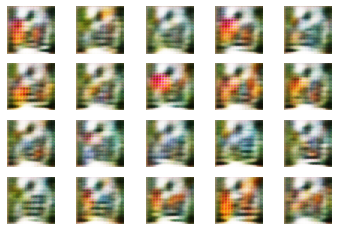

In [120]:
[X, _], _ = generate_fake_class_sample(generator, class_label=2, latent_dim=400, n_samples=20)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot images
for i in range(20):
  # define subplot
  pyplot.subplot(4, 5, 1 + i)
  # turn off axis
  pyplot.axis('off')
  # plot raw pixel data
  # pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
  pyplot.imshow(X[i, :, :])

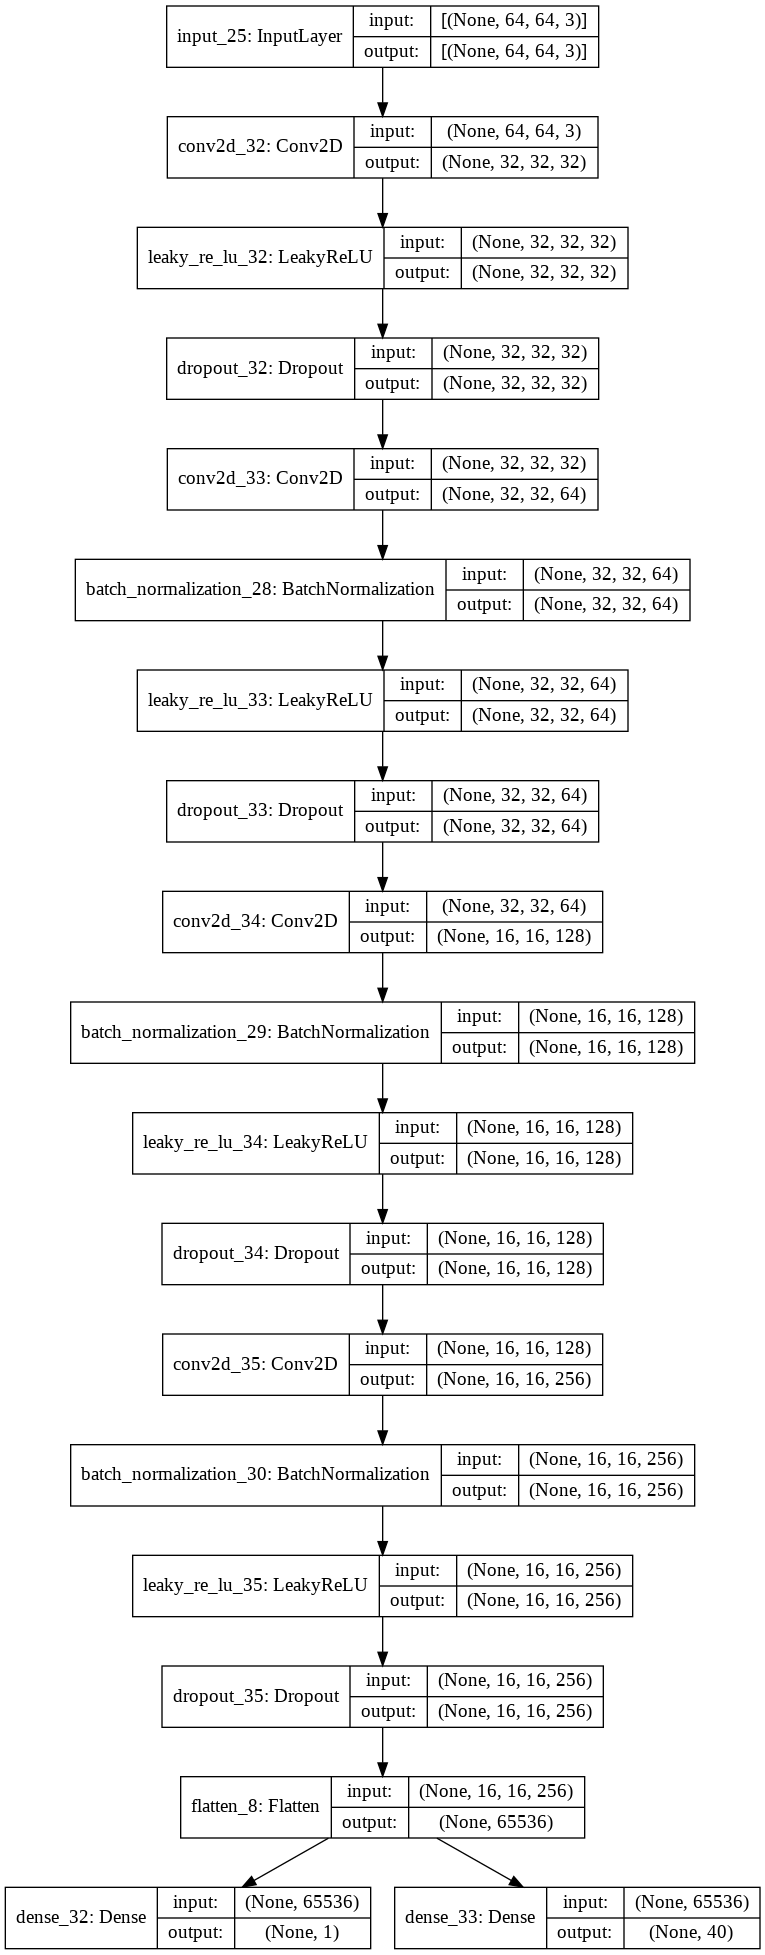

In [117]:
from keras.utils.vis_utils import plot_model
plot_model(generator, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)
plot_model(discriminator, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

# ThoughtViz

**Complete the following steps before running the cells below**

1.
Change runtime to GPU 

>Runtime > Change runtime type > GPU

2.
For each of the following links, add a Google Drive shortcut to your Drive root folder(My Drive):

>https://drive.google.com/file/d/1atP9CsjWIT-hg3fX--fcC1hg0uvg9bEH/view

>https://drive.google.com/file/d/1x32IulYeBVmkshEKweijMX3DK1Wu8odx/view

>https://drive.google.com/file/d/1cq8RTBiwqO-Jo0TZjBNlRHZEhjKDknKP/view

>https://drive.google.com/file/d/1U9qtN1SlOS3dzd2BwWWHhJiMz_0yNW9U/view

>https://drive.google.com/file/d/1uFFhvTsU2nmdaecR2WPWsiGJfgI3as1_/view

**Mount drive and download project**

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

In [ ]:
!git clone "https://github.com/ptirupat/ThoughtViz.git" "/content/ThoughtViz"

**Unzip project files**

In [ ]:
!unzip -q "/content/gdrive/My Drive/data.zip" -d "/content/ThoughtViz" 
!unzip -q "/content/gdrive/My Drive/images.zip" -d "/content/ThoughtViz/training"
!unzip -q "/content/gdrive/My Drive/eeg_models.zip" -d "/content/ThoughtViz/models" 
!unzip -q "/content/gdrive/My Drive/trained_classifier_models.zip" -d "/content/ThoughtViz/training"
!unzip -q "/content/gdrive/My Drive/gan_models.zip" -d "/content/ThoughtViz/models"
!echo "Download Finished!"

**Update outdated module calls and make code compatible with colab environment**

In [ ]:
# Update Keras module structure
!sed -i "s/keras.layers/keras/" ThoughtViz/layers/mog_layer.py

# Change System Path
!sed -i "1i import sys\nsys.path.insert(0,'/content/ThoughtViz')\n" /content/ThoughtViz/testing/test.py
!sed -i "s/\..\//\/content\/ThoughtViz\//" ThoughtViz/testing/test.py

# Rename GAN model directory to match code
!mv /content/ThoughtViz/models/gan_models/thoughtviz/ /content/ThoughtViz/models/gan_models/final/

**Test code**

Note: Images are not saved by default. 
>To save the output image, you must edit the *ThoughtViz/testing/test.py* file and add the line **img.save('output.png')** after *img.show()* in the *test_deligan_final* function. 

In [ ]:
!python3 ThoughtViz/testing/test.py

# EEG decoding to images - Converting Data

**Convert to NPY**

Code provided by: *https://github.com/perceivelab/eeg_visual_classification/blob/main/eeg_signal_classification.py*

In [ ]:
import torch

def pth_to_npy(path):
      torch_file = torch.load(path)

      torch_dataset = torch_file["dataset"]
      torch_labels = torch_file["labels"]
      torch_images = torch_file["images"]
      torch_size = len(torch_dataset)

      return torch_dataset, torch_labels, torch_images, torch_size

torch_dataset, torch_labels, torch_images, torch_size = pth_to_npy(data_path)
# # Dataset class
# class EEGDataset:
    
#     # Constructor
#     def __init__(self, eeg_signals_path):
#         # Load EEG signals
#         loaded = torch.load(eeg_signals_path)
#         if opt.subject!=0:
#             self.data = [loaded['dataset'][i] for i in range(len(loaded['dataset']) ) if loaded['dataset'][i]['subject']==opt.subject]
#         else:
#             self.data=loaded['dataset']        
#         self.labels = loaded["labels"]
#         self.images = loaded["images"]
        
#         # Compute size
#         self.size = len(self.data)

#     # Get size
#     def __len__(self):
#         return self.size

#     # Get item
#     def __getitem__(self, i):
#         # Process EEG
#         eeg = self.data[i]["eeg"].float().t()
#         eeg = eeg[opt.time_low:opt.time_high,:]

#         if opt.model_type == "model10":
#             eeg = eeg.t()
#             eeg = eeg.view(1,128,opt.time_high-opt.time_low)
#         # Get label
#         label = self.data[i]["label"]
#         # Return
#         return eeg, label

In [ ]:
print("size:", torch_size)

size: 11965


In [ ]:
# print("dataset 0:", torch_dataset[0])
eeg = torch_dataset[0]["eeg"]
image_num = torch_dataset[0]["image"]
label = torch_dataset[0]["label"]
subject = torch_dataset[0]["subject"]

print("eeg data:", eeg)
print("image number:", image_num)
print("image label:", label)
print("participant number:", subject)

trimmed_eeg = eeg.float().t()[40:460]
print("eeg data trimmed:", trimmed_eeg)

numpy_eeg = trimmed_eeg.numpy()
print("eeg data trimmed+numpy:", numpy_eeg)


eeg data: tensor([[-0.0098,  0.0195,  0.0620,  ...,  0.0638,  0.0120, -0.0118],
        [-0.0045,  0.1303,  0.2673,  ...,  0.0894,  0.0342, -0.0082],
        [ 0.0215, -0.2017, -0.4305,  ..., -0.2022, -0.0940,  0.0188],
        ...,
        [ 0.0160,  0.0707,  0.1005,  ...,  0.2066,  0.1156,  0.0036],
        [-0.0046, -0.0084, -0.0119,  ...,  0.0007, -0.0026, -0.0053],
        [ 0.0040,  0.0419,  0.0665,  ...,  0.0765,  0.0309, -0.0063]])
image number: 0
image label: 10
participant number: 4
eeg data trimmed: tensor([[-0.4191,  0.0019, -0.2101,  ..., -0.1909, -0.0154, -0.0490],
        [-0.3855,  0.0083, -0.1807,  ..., -0.1959, -0.0153, -0.0395],
        [-0.3205,  0.0448, -0.1669,  ..., -0.2303, -0.0169, -0.0532],
        ...,
        [ 0.3540,  0.2597,  0.3852,  ...,  0.3877,  0.0131,  0.1309],
        [ 0.3000,  0.1950,  0.4775,  ...,  0.3140,  0.0086,  0.0727],
        [ 0.2586,  0.1368,  0.5080,  ...,  0.2619,  0.0052,  0.0441]])
eeg data trimmed+numpy: [[-0.41908935  0.00189896 

In [ ]:
print("label 0:", torch_labels[0])
print("label 1:", torch_labels[1])

label 0: n02389026
label 1: n03888257


In [ ]:
print("image 0:", torch_images[0])
print("image 1:", torch_images[1])

for i in range(0,10):
  print(torch_images[i])

image 0: n02951358_31190
image 1: n03452741_16744
n02951358_31190
n03452741_16744
n04069434_10318
n02951358_34807
n03452741_5499
n03376595_247
n02906734_14010
n03452741_2982
n02607072_5873
n02510455_96034


# Visualization

**Download and Import Packages**

In [ ]:
!pip install -U mne
!pip install pyEDFlib

     |████████████████████████████████| 6.9MB 6.3MB/s 
     |████████████████████████████████| 1.2MB 7.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pyEDFlib: filename=pyEDFlib-0.1.20-cp37-cp37m-linux_x86_64.whl size=929386 sha256=0786962b6603f9645ab869be321052ab038c0bce619e7ac1a549112a00fb4d4a
  Stored in directory: /root/.cache/pip/wheels/0d/be/b5/574f8b99ad9ac2ecf78e0c5271040b5aff999febfe655b97a4
Successfully built pyEDFlib


In [ ]:
%matplotlib inline
import mne
import os
import numpy as np
from pyedflib import highlevel

**Define Visualization Functions**

In [ ]:
def create_edf(npy_path, name):
  data = np.load(npy_path)
  # [128,440,11965]
  signals = list(data.T[:,:,:])
  channel_names = list('ch'+str(i) for i in range(0,128))
  signal_headers = highlevel.make_signal_headers(channel_names, sample_rate=1000)
  header = highlevel.make_header()
  highlevel.write_edf(name, signals, signal_headers, header)

def create_edf2(npy_path, name):
  data = np.load(npy_path)
  # [128,11965,440]
  signals = list(data.transpose(2,0,1)[0:ch,0:100,:])
  channel_names = list('ch'+str(i) for i in range(0,128))
  signal_headers = highlevel.make_signal_headers(channel_names, sample_rate=1000)
  header = highlevel.make_header()
  highlevel.write_edf(name, signals, signal_headers, header)

def visualizeData(path):
  raw = mne.io.read_raw_edf(path,preload=True);
  print(raw)
  raw.plot_psd(area_mode='range', fmin=15, fmax=70.0, show=False, average=True);
  raw.plot(duration=2, scalings=0.000002)

In [ ]:
data_path = '/content/gdrive/MyDrive/EEG2Image/data/eeg_14_70.npy'
test_path = '/content/test_file.edf'
rand_path = '/content/edf_file.edf'

In [ ]:
print(data.shape)
print(data[::1,1].shape)
print(data[::1,2].shape)
print(data[1::].shape)
print(data[2::].shape)
print(data.T[0,0].shape)
print(data.T.shape)
print(data.T[:,:,0:10].shape)
print(data.T[:,:,0:10].reshape(128,440*10).shape)
print(data.transpose(2,0,1).shape)
print(data.transpose(2,0,1)[:,0:10,:].shape)
data.transpose(2,0,1)[0:10,0:10,:].reshape((128,440*10)).shape


(11965, 440, 128)
(11965, 128)
(11965, 128)
(11964, 440, 128)
(11963, 440, 128)
(11965,)
(128, 440, 11965)
(128, 440, 10)
(128, 4400)
(128, 11965, 440)
(128, 10, 440)


(128, 4400)

Extracting EDF parameters from /content/test_file.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 43999  =      0.000 ...    43.999 secs...
<RawEDF | test_file.edf, 5 x 44000 (44.0 s), ~1.7 MB, data loaded>
Effective window size : 2.048 (s)


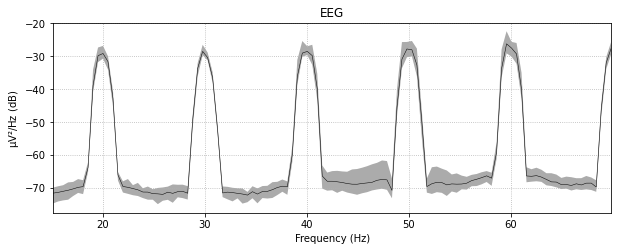

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


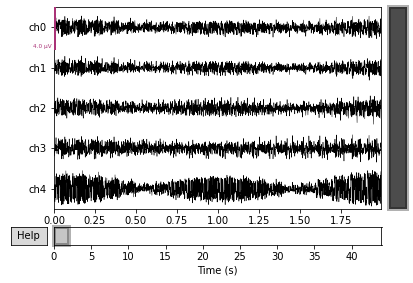

In [ ]:
# write an edf file
ch = 5
signals = list(data.T[0:ch,:,0:100].reshape(ch,440*100))
channel_names = list('ch'+str(i) for i in range(0,ch))
signal_headers = highlevel.make_signal_headers(channel_names, sample_rate=1000)
header = highlevel.make_header(patientname='patient_x', gender='Female')
highlevel.write_edf('test_file.edf', signals, signal_headers, header)

visualizeData(test_path)

Extracting EDF parameters from /content/test_file.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 43999  =      0.000 ...    43.999 secs...
<RawEDF | test_file.edf, 5 x 44000 (44.0 s), ~1.7 MB, data loaded>
Effective window size : 2.048 (s)


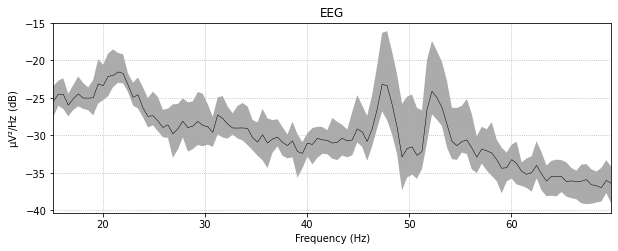

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


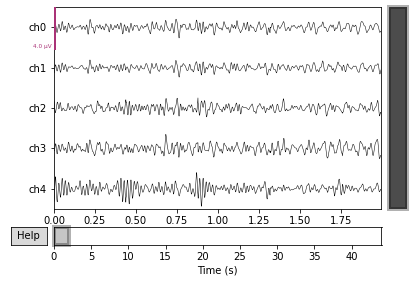

In [ ]:
# write an edf file
ch = 5
signals = list(data.transpose(2,0,1)[0:ch,0:100,:])
channel_names = list('ch'+str(i) for i in range(0,ch))
signal_headers = highlevel.make_signal_headers(channel_names, sample_rate=1000)
header = highlevel.make_header()
highlevel.write_edf('test_file.edf', signals, signal_headers, header)

visualizeData(test_path)

Extracting EDF parameters from /content/test_file.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 43999  =      0.000 ...    43.999 secs...
<RawEDF | test_file.edf, 50 x 44000 (44.0 s), ~16.8 MB, data loaded>
Effective window size : 2.048 (s)


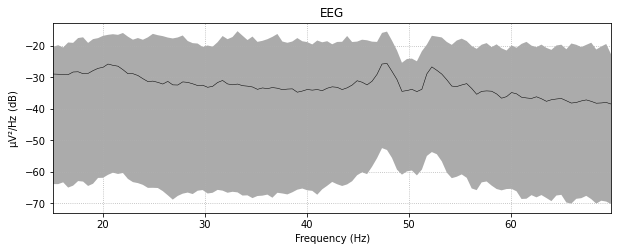

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


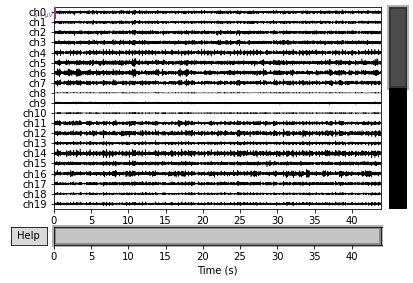

In [ ]:
# write an edf file
ch = 50
signals = list(data.transpose(2,0,1)[0:ch,0:100,:])
channel_names = list('ch'+str(i) for i in range(0,ch))
signal_headers = highlevel.make_signal_headers(channel_names, sample_rate=1000)
header = highlevel.make_header()
highlevel.write_edf('test_file.edf', signals, signal_headers, header)

visualizeData(test_path)

Extracting EDF parameters from /content/test_file.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 43999  =      0.000 ...    43.999 secs...
<RawEDF | test_file.edf, 100 x 44000 (44.0 s), ~33.7 MB, data loaded>
Effective window size : 2.048 (s)


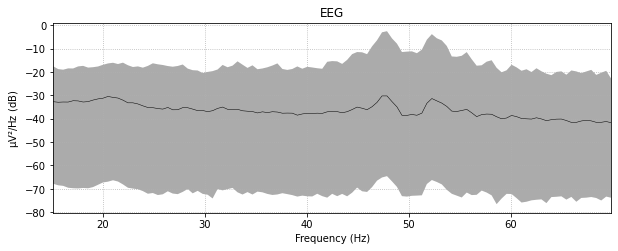

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


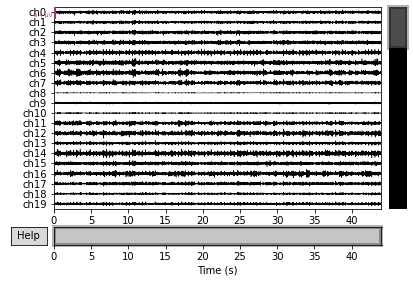

Extracting EDF parameters from /content/test_file.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 439999  =      0.000 ...   439.999 secs...
<RawEDF | test_file.edf, 100 x 440000 (440.0 s), ~335.8 MB, data loaded>
Effective window size : 2.048 (s)


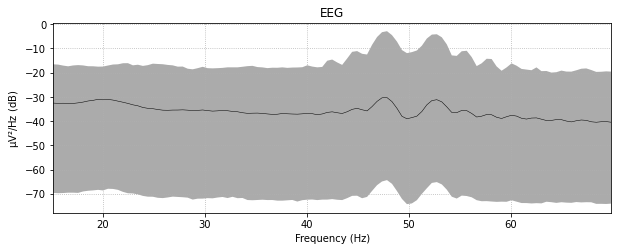

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


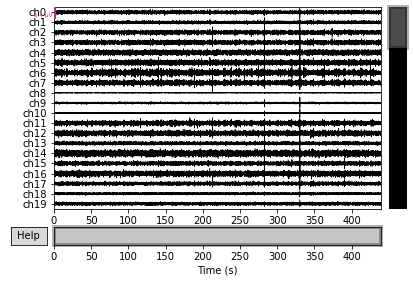

In [ ]:
visualizeData(test_path)

Extracting EDF parameters from /content/test_file.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 43999  =      0.000 ...    43.999 secs...
<RawEDF | test_file.edf, 100 x 44000 (44.0 s), ~33.7 MB, data loaded>
Effective window size : 2.048 (s)


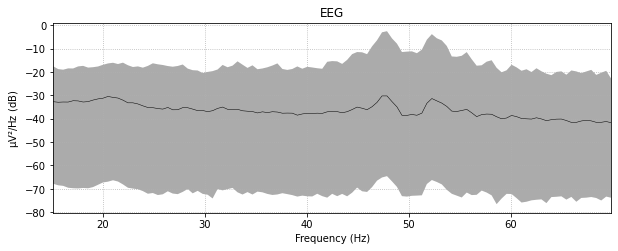

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


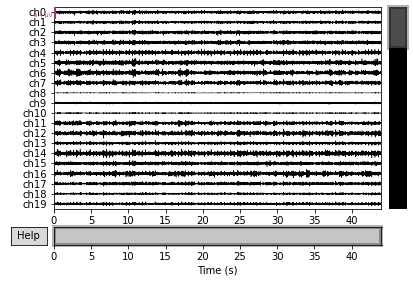

In [ ]:
visualizeData(test_path)

**LSTM stuff**

In [ ]:
# Code goes here #

**GAN stuff**

In [ ]:
# Code goes here #

**Test Code**

In [ ]:
# Code goes here #